In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Dataset/BFDORIGINAL.zip"

Streaming output truncated to the last 5000 lines.
  inflating: BFDORIGINAL/train/not fractured/50-rotated3-rotated1-rotated3.jpg  
  inflating: __MACOSX/BFDORIGINAL/train/not fractured/._50-rotated3-rotated1-rotated3.jpg  
  inflating: BFDORIGINAL/train/not fractured/68-rotated3-rotated3-rotated2.jpg  
  inflating: __MACOSX/BFDORIGINAL/train/not fractured/._68-rotated3-rotated3-rotated2.jpg  
  inflating: BFDORIGINAL/train/not fractured/40-rotated3-rotated2.jpg  
  inflating: __MACOSX/BFDORIGINAL/train/not fractured/._40-rotated3-rotated2.jpg  
  inflating: BFDORIGINAL/train/not fractured/34-rotated1-rotated2-rotated2.jpg  
  inflating: __MACOSX/BFDORIGINAL/train/not fractured/._34-rotated1-rotated2-rotated2.jpg  
  inflating: BFDORIGINAL/train/not fractured/43-rotated2-rotated2-rotated2-rotated1.jpg  
  inflating: __MACOSX/BFDORIGINAL/train/not fractured/._43-rotated2-rotated2-rotated2-rotated1.jpg  
  inflating: BFDORIGINAL/train/not fractured/30-rotated3-rotated1.jpg  
  inflating:

In [ ]:
import cv2
import os
import numpy as np
from tqdm import tqdm
import sklearn
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint

In [ ]:
img = cv2.imread("/content/BFDORIGINAL/train/fractured/10-rotated1-rotated1-rotated1.jpg")
img.shape

(224, 224, 3)

In [ ]:
base_path = "/content/BFDORIGINAL"
IMAGE_SIZE = 224
BATCH_SIZE = 12
VERBOSE = 1

In [ ]:
class_names = ["fractured", "not fractured"]

In [ ]:
x_train=[]
y_train=[]

for i in class_names:
    count = 0
    folder_path = os.path.join(os.path.join(base_path,"train"), i)
    for j in tqdm(os.listdir(folder_path), ncols=70):
        if count == 450:
          break
        count += 1
        img = cv2.imread(os.path.join(folder_path,j))
        img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
        x_train.append(img)
        y_train.append(i)
print('Train Dataset Loading complete')

for i in class_names:
    count = 0
    folder_path = os.path.join(os.path.join(base_path,"val"), i)
    for j in tqdm(os.listdir(folder_path), ncols=70):
        if count == 450:
          break
        count += 1
        img = cv2.imread(os.path.join(folder_path,j))
        img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
        x_train.append(img)
        y_train.append(i)
print('Test Dataset Loading complete')

x_train = np.array(x_train)
y_train = np.array(y_train)


x_train, y_train = sklearn.utils.shuffle(x_train, y_train, random_state=0)

 10%|██▊                         | 450/4383 [00:00<00:03, 1293.82it/s]


Train Dataset Loading complete


100%|██████████████████████████████| 240/240 [00:00<00:00, 947.30it/s]


Test Dataset Loading complete


['fractured' 'not fractured']
[810 690]


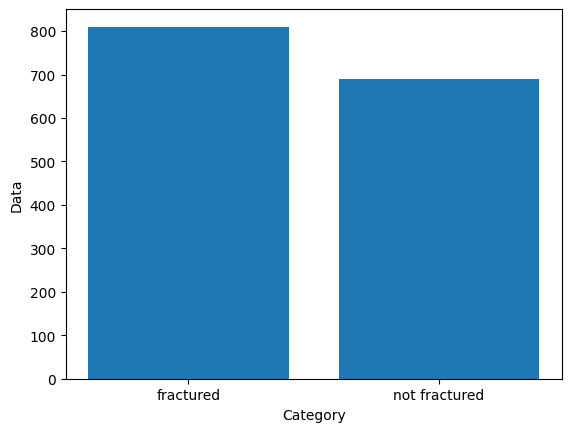

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
print(unique)
print(counts)
plt.bar(unique,counts,align='center')
plt.xlabel('Category')
plt.ylabel('Data')
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, random_state=47, test_size=0.10)

print("Shapes X : Train :",x_train.shape,  " Test :",x_test.shape)
print("Shapes Y : Train :",y_train.shape,  " Test :",y_test.shape)

Shapes X : Train : (1350, 224, 224, 3)  Test : (150, 224, 224, 3)
Shapes Y : Train : (1350,)  Test : (150,)


In [ ]:
y_train_new = [class_names.index(i) for i in y_train]
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = [class_names.index(i) for i in y_test]
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
print(y_train[1])
print(y_train[2])

[0. 1.]
[1. 0.]


In [ ]:
print(np.argmax(y_train[1]))
print(np.argmax(y_train[2]))

1
0


In [ ]:
classes = np.unique(np.argmax(y_train, axis=1))
print(classes)

[0 1]


In [ ]:
mapping = dict(zip(classes, class_names))
mapping

{0: 'fractured', 1: 'not fractured'}

In [ ]:
inputShape = (IMAGE_SIZE, IMAGE_SIZE, 3)
resnet = ResNet50(weights="imagenet", input_shape=inputShape, include_top=False)

94765736/94765736 [==============================] - 9s 0us/step


In [ ]:
model = resnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(len(classes), activation='softmax')(model)
model = tf.keras.models.Model(inputs=resnet.input, outputs=model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("denset121.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,mode='auto',verbose=VERBOSE)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE,validation_data=(x_test, y_test), steps_per_epoch=len(x_train) // BATCH_SIZE,epochs=12, callbacks=[reduce_lr, checkpoint, tensorboard])

Epoch 1/12
112/112 [==============================] - ETA: 0s - loss: 0.8694 - accuracy: 0.6384
Epoch 1: val_accuracy improved from -inf to 0.44667, saving model to denset121.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 79s 329ms/step - loss: 0.8694 - accuracy: 0.6384 - val_loss: 97.2047 - val_accuracy: 0.4467 - lr: 0.0010
Epoch 2/12
112/112 [==============================] - ETA: 0s - loss: 0.7430 - accuracy: 0.6413
Epoch 2: val_accuracy improved from 0.44667 to 0.55333, saving model to denset121.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 41s 355ms/step - loss: 0.7430 - accuracy: 0.6413 - val_loss: 3072.9951 - val_accuracy: 0.5533 - lr: 0.0010
Epoch 3/12
112/112 [==============================] - ETA: 0s - loss: 0.6186 - accuracy: 0.7048
Epoch 3: val_accuracy did not improve from 0.55333
112/112 [==============================] - 37s 331ms/step - loss: 0.6186 - accuracy: 0.7048 - val_loss: 378.6715 - val_accuracy: 0.5533 - lr: 0.0010
Epoch 4/12
112/112 [==============================] - ETA: 0s - loss: 0.6085 - accuracy: 0.7040
Epoch 4: val_accuracy improved from 0.55333 to 0.68667, saving model to denset121.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 40s 362ms/step - loss: 0.6085 - accuracy: 0.7040 - val_loss: 1.7954 - val_accuracy: 0.6867 - lr: 0.0010
Epoch 5/12
112/112 [==============================] - ETA: 0s - loss: 0.5036 - accuracy: 0.7586
Epoch 5: val_accuracy improved from 0.68667 to 0.78000, saving model to denset121.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 42s 376ms/step - loss: 0.5036 - accuracy: 0.7586 - val_loss: 1.0686 - val_accuracy: 0.7800 - lr: 0.0010
Epoch 6/12
112/112 [==============================] - ETA: 0s - loss: 0.4570 - accuracy: 0.8004
Epoch 6: val_accuracy did not improve from 0.78000
112/112 [==============================] - 48s 429ms/step - loss: 0.4570 - accuracy: 0.8004 - val_loss: 0.5496 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 7/12
112/112 [==============================] - ETA: 0s - loss: 0.3901 - accuracy: 0.8109
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 7: val_accuracy did not improve from 0.78000
112/112 [==============================] - 44s 392ms/step - loss: 0.3901 - accuracy: 0.8109 - val_loss: 0.7625 - val_accuracy: 0.5800 - lr: 0.0010
Epoch 8/12
112/112 [==============================] - ETA: 0s - loss: 0.3332 - accuracy: 0.8617
Epoch 8: val_accuracy did not improve from 0.78000
112/112 [==============================] 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 39s 348ms/step - loss: 0.3143 - accuracy: 0.8580 - val_loss: 0.3067 - val_accuracy: 0.8600 - lr: 3.0000e-04
Epoch 10/12
112/112 [==============================] - ETA: 0s - loss: 0.2501 - accuracy: 0.8976
Epoch 10: val_accuracy did not improve from 0.86000
112/112 [==============================] - 38s 340ms/step - loss: 0.2501 - accuracy: 0.8976 - val_loss: 0.3858 - val_accuracy: 0.8467 - lr: 3.0000e-04
Epoch 11/12
112/112 [==============================] - ETA: 0s - loss: 0.2719 - accuracy: 0.8842
Epoch 11: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.

Epoch 11: val_accuracy did not improve from 0.86000
112/112 [==============================] - 41s 369ms/step - loss: 0.2719 - accuracy: 0.8842 - val_loss: 0.4189 - val_accuracy: 0.8000 - lr: 3.0000e-04
Epoch 12/12
112/112 [==============================] - ETA: 0s - loss: 0.2005 - accuracy: 0.9185
Epoch 12: val_accuracy improved from 0.86000 to 0.89333, saving model to d

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 46s 415ms/step - loss: 0.2005 - accuracy: 0.9185 - val_loss: 0.2601 - val_accuracy: 0.8933 - lr: 9.0000e-05


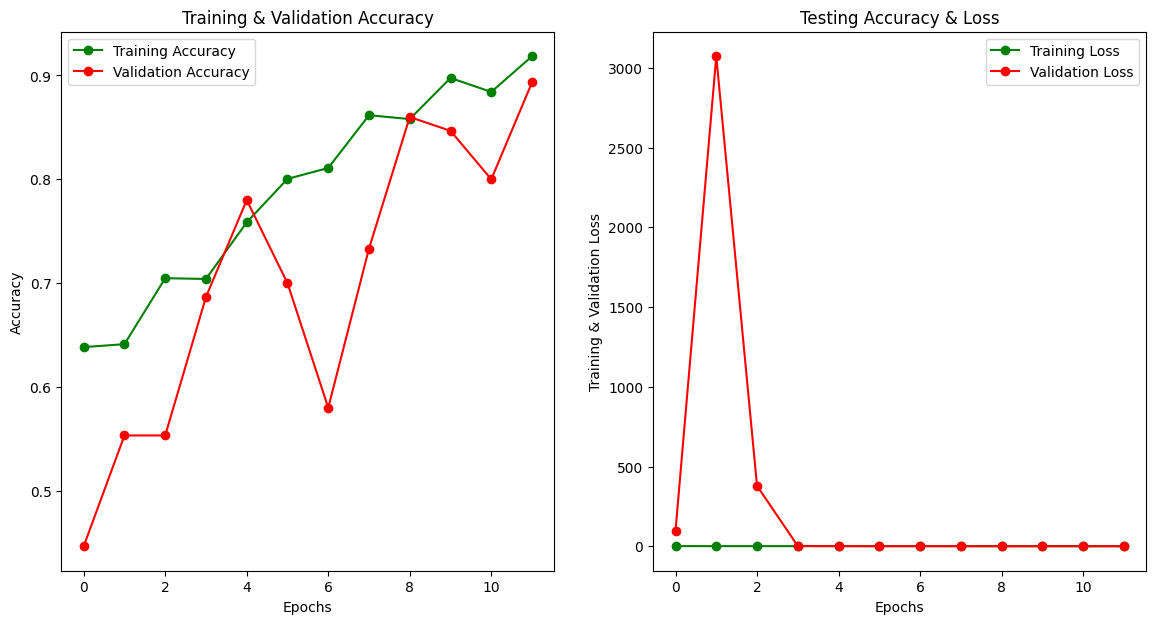

In [ ]:
epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(14, 7)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss, 'g-o', label ='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')
plt.show()

In [ ]:
result = model.evaluate(x_test, y_test)
print("Testing Loss :", result[0])
print("Testing Accuracy :", result[1]*100, "%")

5/5 [==============================] - 5s 715ms/step - loss: 0.2601 - accuracy: 0.8933
Testing Loss : 0.260093092918396
Testing Accuracy : 89.33333158493042 %


In [ ]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis = 1)
y_test_edit = np.argmax(y_test , axis = 1)

5/5 [==============================] - 3s 390ms/step


In [ ]:
cf_report = sklearn.metrics.classification_report(y_test_edit, predictions)
print(cf_report)

              precision    recall  f1-score   support

           0       0.85      0.99      0.91        83
           1       0.98      0.78      0.87        67

    accuracy                           0.89       150
   macro avg       0.91      0.88      0.89       150
weighted avg       0.91      0.89      0.89       150



<Axes: >

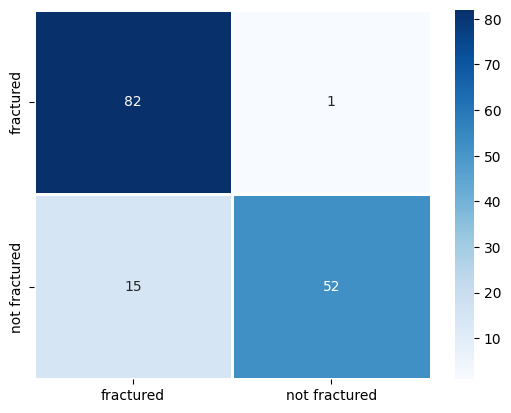

In [ ]:
import sklearn
import seaborn as sns
cf_matrix = sklearn.metrics.confusion_matrix(y_test_edit, predictions)
sns.heatmap(cf_matrix, cmap = 'Blues', linewidth = 1, annot = True, xticklabels=class_names, yticklabels=class_names)

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 8.3 MB/s eta 0:00:00


In [ ]:
import shap

In [ ]:
shap.initjs()

In [ ]:
masker = shap.maskers.Image("inpaint_telea", x_train[0].shape)

explainer = shap.Explainer(model, masker, output_names=class_names)

explainer

In [ ]:
shap_values = explainer(x_test[:4], outputs=shap.Explanation.argsort.flip[:5])

shap_values.shape

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 1/4 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 3/4 [01:14<00:13, 13.72s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 4/4 [01:44<00:00, 20.33s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 5it [02:07, 31.95s/it]


(4, 224, 224, 3, 2)

In [ ]:
print("Actual Labels    : {}".format([mapping[i] for i in np.argmax(y_test[:4], axis=1)]))
probs = model.predict(x_test[:4])
print("Predicted Labels : {}".format([mapping[i] for i in np.argmax(probs, axis=1)]))
print("Probabilities : {}".format(np.max(probs, axis=1)))

Actual Labels    : ['not fractured', 'fractured', 'fractured', 'not fractured']
1/1 [==============================] - 2s 2s/step
Predicted Labels : ['not fractured', 'fractured', 'fractured', 'not fractured']
Probabilities : [0.91855764 0.99318695 0.99999    0.920352  ]


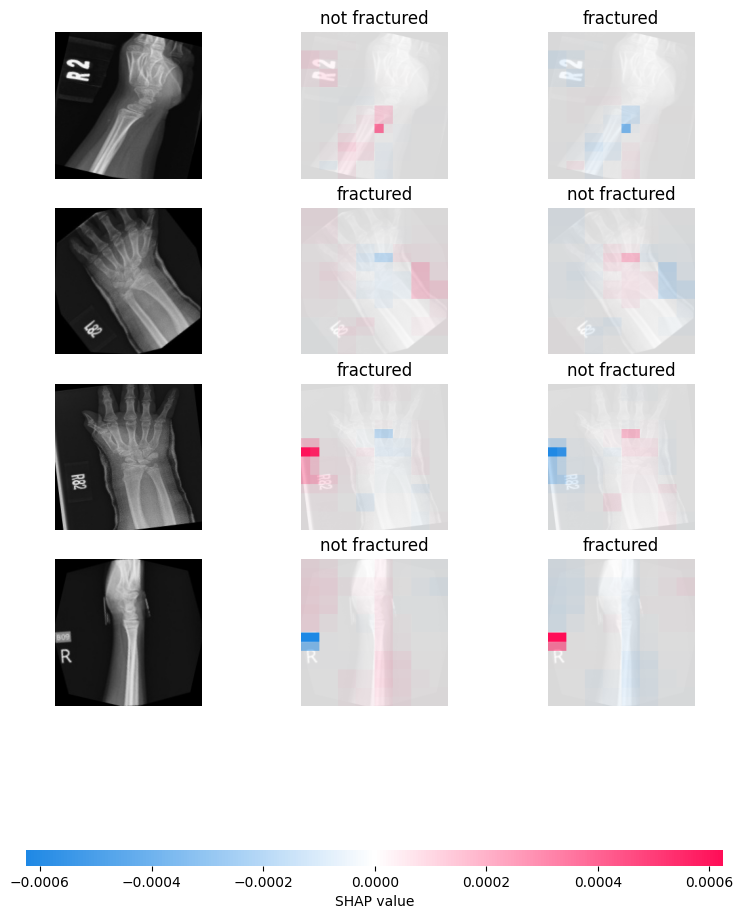

In [ ]:
shap.image_plot(shap_values)

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 1/4 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 3/4 [00:55<00:13, 13.93s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 4/4 [01:25<00:00, 20.80s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 5it [01:50, 27.57s/it]


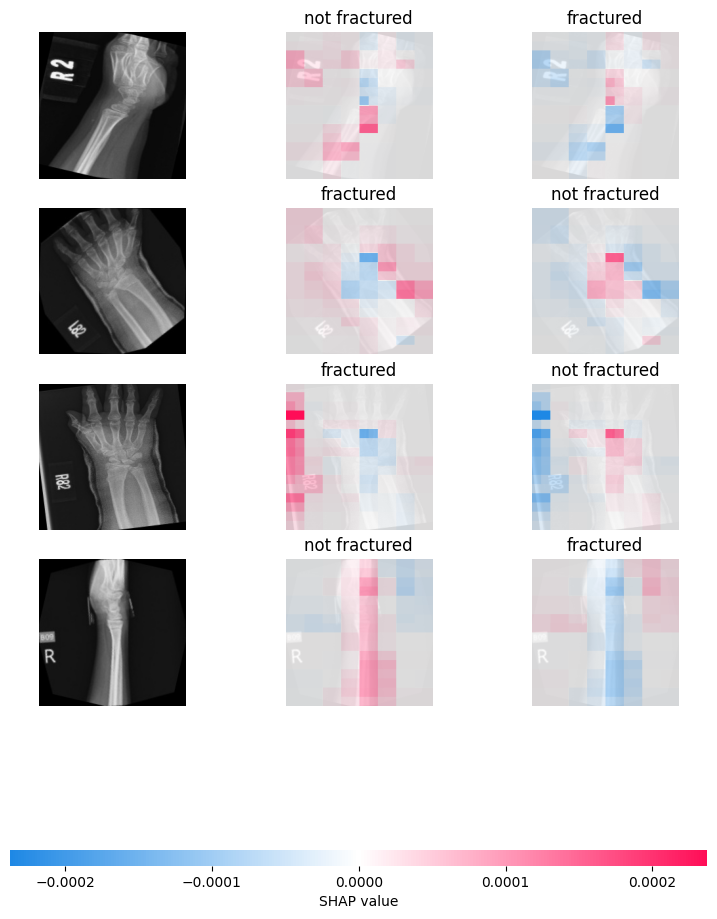

In [ ]:
masker = shap.maskers.Image("inpaint_ns", x_train[0].shape)

explainer = shap.Explainer(model, masker, output_names=class_names)

shap_values = explainer(x_test[:4], outputs=shap.Explanation.argsort.flip[:5])

shap.image_plot(shap_values)

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 2/4 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 4/4 [00:19<00:00,  3.52s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 5it [00:26,  8.86s/it]


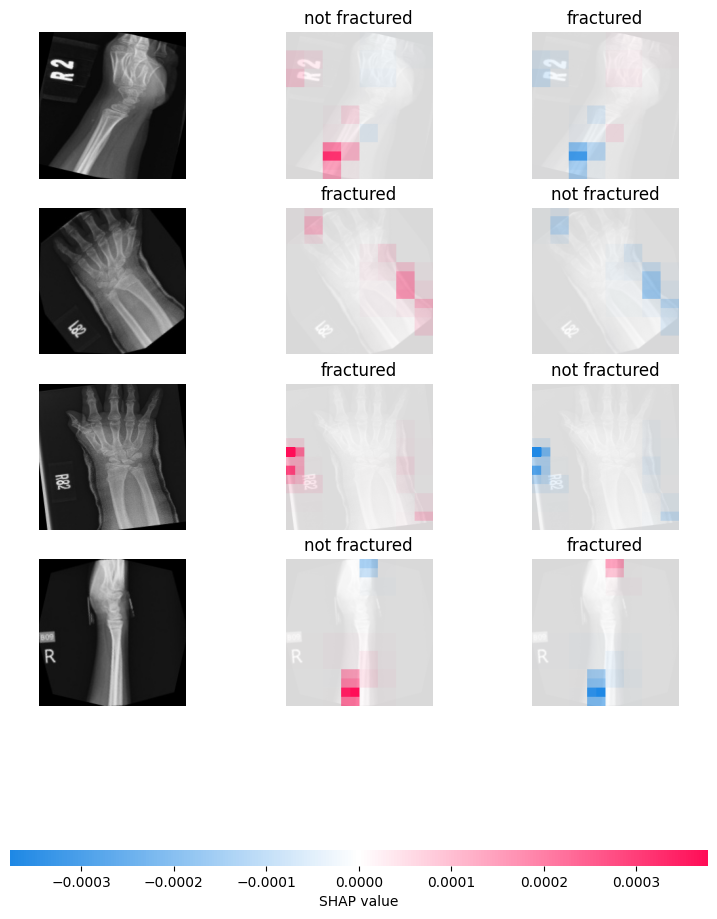

In [ ]:
masker = shap.maskers.Image("blur(28,28)", x_train[0].shape)

explainer = shap.Explainer(model, masker, output_names=class_names)

shap_values = explainer(x_test[:4], outputs=shap.Explanation.argsort.flip[:5])

shap.image_plot(shap_values)

In [ ]:
def input_img(path):
  image = tf.image.decode_png(tf.io.read_file(path))
  image = x_test[0] # Hardcoded Test Image 0
  image = tf.expand_dims(image, axis=0)
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [224,224])
  return image

def normalize_image(img):
  grads_norm = img[:,:,0]+ img[:,:,1]+ img[:,:,2]
  grads_norm = (grads_norm - tf.reduce_min(grads_norm))/ (tf.reduce_max(grads_norm)-
  tf.reduce_min(grads_norm))
  return grads_norm

def plot_maps(img1, img2,vmin=0.3,vmax=0.7, mix_val=2):
  f = plt.figure(figsize=(15,45))
  plt.subplot(1,3,1)
  plt.imshow(img1,vmin=vmin, vmax=vmax, cmap="ocean")
  plt.axis("off")
  plt.subplot(1,3,2)
  plt.imshow(img2, cmap = "ocean")
  plt.axis("off")
  plt.subplot(1,3,3)
  plt.imshow(img1*mix_val+img2/mix_val, cmap = "ocean" )
  plt.axis("off")

In [ ]:
img_path = '/content/BFDORIGINAL/train/fractured/10-rotated1-rotated1-rotated1.jpg'
input_img = input_img(img_path)

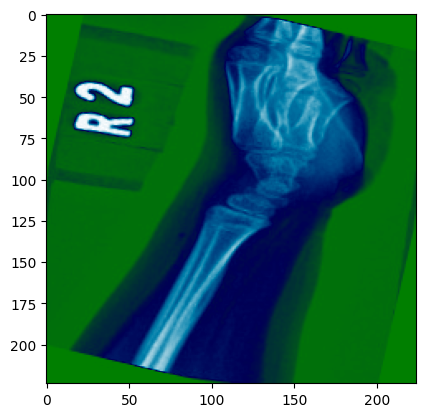

In [ ]:
plt.imshow(normalize_image(input_img[0]), cmap = "ocean")

In [ ]:
result = model(input_img)
max_idx = tf.argmax(result,axis = 1)

In [ ]:
max_idx

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>

In [ ]:
result

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.08144242, 0.91855764]], dtype=float32)>

In [ ]:
with tf.GradientTape() as tape:
  tape.watch(input_img)
  result = model(input_img)
  max_score = result[0,max_idx[0]]

In [ ]:
max_score

<tf.Tensor: shape=(), dtype=float32, numpy=0.91855764>

In [ ]:
grads = tape.gradient(max_score, input_img)

In [ ]:
grads

<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[ 1.8145383e-07, -1.9887960e-07,  6.8579284e-09],
         [ 2.0617682e-07, -2.4886117e-07, -3.9214299e-08],
         [ 1.7671130e-07, -2.2018438e-07, -5.4102713e-09],
         ...,
         [-5.5163046e-10, -3.4068331e-10, -1.0406764e-09],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

        [[ 2.0526228e-07, -2.3310524e-07, -2.0489498e-08],
         [ 2.8432910e-07, -2.5382616e-07, -4.5496385e-08],
         [ 2.2626213e-07, -2.4088530e-07, -3.0590023e-08],
         ...,
         [-4.5960902e-10, -3.9258580e-10, -6.7011174e-10],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

        [[ 1.4057190e-07, -2.1085675e-07, -1.7592590e-08],
         [ 2.1354238e-07, -2.3607434e-07, -5.9323082e-08],
         [ 1.9699405e-07, -1.9853496e-07, -3.2280909e-08],
         ...,
         [-

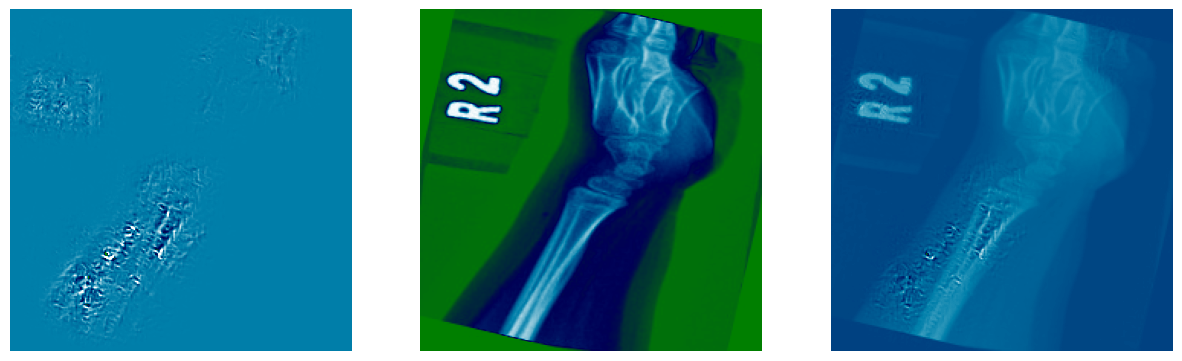

In [ ]:
plot_maps(normalize_image(grads[0]), normalize_image(input_img[0]))